<a href="https://colab.research.google.com/github/wiiloebis/bangkit_machine_learning_assigment/blob/master/Alexnet_flower_multiclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libs needed

In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import tensorflow as tf
from tensorflow.keras import layers
os.listdir(path='.')
try:
    import split_folders
except ModuleNotFoundError:
    ! pip install split-folders

# Check Tensorflow Version

In [3]:
tf.__version__

'2.2.0'

In [4]:
# Preparing kaggle environment to download the dataset. For a reference of how to get kaggle.json, please see https://www.kaggle.com/general/74235
! pip install -q kaggle
from google.colab import files
files.upload() # upload kaggle.jsontomato_class_list = get_sub_dir_names(train_dir_name)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"winniseptiani","key":"805a0b70529185cca7c56d880e4bd576"}'}

In [5]:
# Download and split the dataset into train/val dataset
# The data set source https://www.kaggle.com/alxmamaev/flowers-recognition

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alxmamaev/flowers-recognition
! unzip -q flowers-recognition.zip

import split_folders
collection_dir = 'flower_dataset'

split_folders.ratio(input='flowers', output=collection_dir, ratio=(.7, .3))

 99% 446M/450M [00:02<00:00, 195MB/s]
100% 450M/450M [00:02<00:00, 199MB/s]


Copying files: 4326 files [00:00, 6199.60 files/s]


# Define a function to get directories name/path

In [29]:
# def get_file_path_in_dir(dir_name):
#     ''' Get the full path name of files/folders in
#     directory specified by path to directory in
#     argument "dir_name" and return it as a list

#     dir_name is a Path from the directory of your current working script to the folder that you want to
#     check all of the subfolder/file
#     example:
#     pwd
#     /usr/Documents
#     ls .
#     Music
#     document.txt

#     get_file_path_in_dir('usr/Documents')
#     returns
#     [/usr/Documents/Music,
#     /usr/Documents/document.txt]
#     '''
#     target_dir = os.listdir(dir_name)
#     dir_list = []
#     for entry in target_dir:
#         full_path = os.path.join(dir_name, entry)
#         dir_list.append(full_path)
    
#     return dir_list

def get_file_path_in_dir(dir_name):
    ''' Get the full path name of files/folders in
    directory specified by path to directory in
    argument "dir_name" and return it as a list

    dir_name is a Path from the directory of your current working script to the folder that you want to
    check all of the subfolder/file
    example:
    pwd
    /usr/Documents
    ls .
    Music
    document.txt

    get_file_path_in_dir('usr/Documents')
    returns
    [/usr/Documents/Music,
    /usr/Documents/document.txt]
    '''
    target_dir = os.listdir(dir_name)
    dir_list = []
    for entry in target_dir:
        full_path = os.path.join(dir_name, entry)
        print("directory path", target_dir)
        print("full path", full_path)
        dir_list.append(full_path)
    
    return dir_list

# Define a function to get folder/file in a directory

In [30]:
def get_sub_dir_names(path_to_dir):
    '''Get the name of all file/folder in a directory specified
    by the path "path_to_dir" and return it as list
    example:
    pwd
    /usr/Documents
    ls .
    Music
    documents.txt

    get_sub_dir_names('usr/Documents')
    returns
    ['Music',
    'documents.txt']

    '''
    subdir_path_list = get_file_path_in_dir(path_to_dir)
    subdir_name_list = []
    for subdir in subdir_path_list:
        subdir_name_list.append(subdir.split("\\")[-1])
    return subdir_name_list

def load_images(directory):
    fileNames = []
    for filename in os.listdir(directory):
      fileName = os.path.join(directory, filename)
      fileNames.append(fileName)
    return fileNames

# Get the full path of each subdirectory in a directory specify by the variable train_dir_name
train_dir_name contain path from current working directory(relative path) to the directory containing

In [32]:
# get every path to subfolder/file in train_dir_name folder
train_dir_name = os.path.join(collection_dir, 'train')
# train_dir_name = 'flower_dataset\\train\\'
train_data_dir = get_file_path_in_dir(train_dir_name)
train_data_dir

directory path ['sunflower', 'tulip', 'rose', 'flowers', 'dandelion', 'daisy']
full path flower_dataset/train/sunflower
directory path ['sunflower', 'tulip', 'rose', 'flowers', 'dandelion', 'daisy']
full path flower_dataset/train/tulip
directory path ['sunflower', 'tulip', 'rose', 'flowers', 'dandelion', 'daisy']
full path flower_dataset/train/rose
directory path ['sunflower', 'tulip', 'rose', 'flowers', 'dandelion', 'daisy']
full path flower_dataset/train/flowers
directory path ['sunflower', 'tulip', 'rose', 'flowers', 'dandelion', 'daisy']
full path flower_dataset/train/dandelion
directory path ['sunflower', 'tulip', 'rose', 'flowers', 'dandelion', 'daisy']
full path flower_dataset/train/daisy


['flower_dataset/train/sunflower',
 'flower_dataset/train/tulip',
 'flower_dataset/train/rose',
 'flower_dataset/train/flowers',
 'flower_dataset/train/dandelion',
 'flower_dataset/train/daisy']

In [33]:
# flower_class_list = get_sub_dir_names(train_dir_name)
flower_class_list = load_images(train_dir_name)
flower_class_list

['flower_dataset/train/sunflower',
 'flower_dataset/train/tulip',
 'flower_dataset/train/rose',
 'flower_dataset/train/flowers',
 'flower_dataset/train/dandelion',
 'flower_dataset/train/daisy']

In [34]:
import PIL
from PIL import Image, ImageOps

In [36]:
def image_to_ndarray(path_to_image):
    """read image from the file path name and
    convert the image to np array with dimension of 200x200x3 pixel
    example:
    image_to_ndarray("usr/Documents/fish.jpg")
    returns
    np.array
    where np.array.shape is (100,100,3)
    """
    image = Image.open(path_to_image)
    # Resize image to 100x100 pixel
    image_resize = ImageOps.fit(image, (100, 100), Image.ANTIALIAS)
    data = np.asarray(image_resize)
    return data

# Read Train image dataset to np array
we will also map each label of the image

In [43]:
# def read_image_dir_to_np_array(dir_name, class_list):
#     """take path to directory name which contains images file,
#        read the image into np array, and return list of image and its corresponding label"""
#     image_dataset = []
#     label = []
#     for cla in class_list:
#         class_items = get_file_path_in_dir(dir_name+"\\"+cla)
#         for item in class_items:
#             data = image_to_ndarray(item)
#             image_dataset.append(data)
#             label.append(cla)

#     return image_dataset, label
def read_image_dir_to_np_array(class_list):
    """take path to directory name which contains images file,
       read the image into np array, and return list of image and its corresponding label"""
    image_dataset = []
    label = []
    print("Class lists:", class_list)
    for cla in class_list:
        print("Class list:", cla)
        class_items = get_file_path_in_dir(cla)
        for item in class_items:
            data = image_to_ndarray(item)
            image_dataset.append(data)
            label.append(cla)

    return image_dataset, label

In [44]:
train_numpy_dataset, label_train = read_image_dir_to_np_array(flower_class_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



UnidentifiedImageError: ignored

# Convert array of image into numpy array
the dimension of the array is as follows: (m, h, w, 3) where m is the number of image, h is the height of each image, w is the width of the image, and 3 is for the number of color channel(RGB)

In [ ]:
train_numpy_dataset = np.array(train_numpy_dataset)
train_numpy_dataset.shape

(18345, 100, 100, 3)

In [ ]:
# Create set of unique labels and make a dictionary that maps the label to unique integer number
label_unique = list(set(label_train))
label_dict = dict((label, index) for index, label in enumerate(label_unique))
label_df = pd.DataFrame(label_dict.items(), columns=['Tomato Health', 'Health Label'])
label_df.to_csv("category_to_num.csv")

In [ ]:
label_dict

{'Tomato___Tomato_mosaic_virus': 0,
 'Tomato___Bacterial_spot': 1,
 'Tomato___Early_blight': 2,
 'Tomato___Spider_mites Two-spotted_spider_mite': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Late_blight': 5,
 'Tomato___Leaf_Mold': 6,
 'Tomato___healthy': 7,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 8,
 'Tomato___Target_Spot': 9}

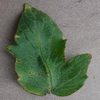

In [ ]:
# label_train
Image.fromarray(train_numpy_dataset[1])

In [ ]:
# map train label to dictionary value
train_numpy_label = np.array([label_dict[key] for key in label_train])
train_numpy_label

array([1, 1, 1, ..., 8, 8, 8])

In [ ]:
train_numpy_label.shape

(18345,)

# Save train dataset and its label as npz file

In [ ]:
np.savez("tomato_leaves100.npz", train_numpy_dataset, train_numpy_label)

# Read validate dataset to np array

In [ ]:
valid_dir_name = 'New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\valid\\'
valid_numpy, label_valid = read_image_dir_to_np_array(valid_dir_name, tomato_class_list)
valid_numpy_label = np.array([label_dict[key] for key in label_valid])

In [ ]:
# Convert list of validation image matrix into np array
valid_numpy = np.array(valid_numpy)
valid_numpy.shape

(4585, 100, 100, 3)

In [ ]:
np.savez("tomato_leaves_test100.npz", valid_numpy, valid_numpy_label)

In [ ]:
valid_numpy_label.shape

(4585,)

## Modelling

In [ ]:
npz_train = np.load('/content/drive/My Drive/tomato/tomato_leaves100.npz')

In [ ]:
x_train = npz_train['arr_0']
y_train = npz_train['arr_1']
y_train.shape

(18345,)

In [ ]:
# shuffle training data
index_shuffle = np.random.permutation(len(x_train))
x_train = x_train[index_shuffle]
y_train = y_train[index_shuffle]

In [ ]:
npz_test = np.load('/content/drive/My Drive/tomato/tomato_leaves_test100.npz')
x_test = npz_test['arr_0']
y_test = npz_test['arr_1']

In [ ]:
# shuffle test data
index_shuffle = np.random.permutation(len(x_test))
x_test = x_test[index_shuffle]
y_test = y_test[index_shuffle]

In [ ]:
y_test

array([6, 8, 8, ..., 9, 7, 0], dtype=int32)

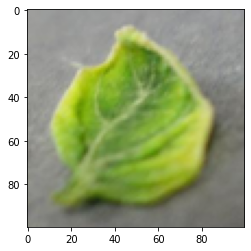

In [ ]:
plt.imshow(x_train[20])

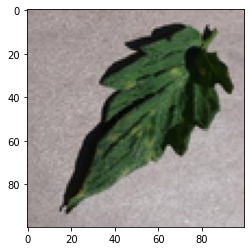

In [ ]:
plt.imshow(x_test[20])

In [ ]:
# define deep neural network model
def create_model(learning_rate,neurons_number=270,regularizer=0.15,dropout_rate=0.4):
  """Create and compile deep neural net model"""
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(tf.keras.layers.Flatten(input_shape=(100, 100, 3)))

  # Define the first hidden layer
  model.add(tf.keras.layers.Dense(units=neurons_number,
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularizer),
                                  name='Hidden1'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=dropout_rate))

  # Define the output layer
  model.add(tf.keras.layers.Dense(units=10,
                                  activation='softmax',
                                  name='Output'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model

## Build a Neural Network

In [ ]:
# define plotting loss function

def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve one or more classification metrics vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()
  plt.show()

In [ ]:
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.05):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split=validation_split)
  
  # The list of epochs of the model
  epochs = history.epoch

  # gather a snapshot of the model's mean squared error
  # at each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist

Train on 11007 samples, validate on 7338 samples
Epoch 1/70
11007/11007 [==============================] - 18s 2ms/sample - loss: 79.1646 - accuracy: 0.1902 - val_loss: 75.4838 - val_accuracy: 0.3367
Epoch 2/70
11007/11007 [==============================] - 16s 1ms/sample - loss: 72.2025 - accuracy: 0.2928 - val_loss: 68.8167 - val_accuracy: 0.4116
Epoch 3/70
11007/11007 [==============================] - 15s 1ms/sample - loss: 65.8552 - accuracy: 0.3598 - val_loss: 62.7825 - val_accuracy: 0.4374
Epoch 4/70
11007/11007 [==============================] - 16s 1ms/sample - loss: 60.1131 - accuracy: 0.3853 - val_loss: 57.3185 - val_accuracy: 0.4550
Epoch 5/70
11007/11007 [==============================] - 16s 1ms/sample - loss: 54.8898 - accuracy: 0.4241 - val_loss: 52.3775 - val_accuracy: 0.4357
Epoch 6/70
11007/11007 [==============================] - 15s 1ms/sample - loss: 50.1454 - accuracy: 0.4410 - val_loss: 47.8385 - val_accuracy: 0.4975
Epoch 7/70
11007/11007 [=====================

11007/11007 [==============================] - 12s 1ms/sample - loss: 2.1175 - accuracy: 0.6057 - val_loss: 2.1283 - val_accuracy: 0.5872
Epoch 56/70
11007/11007 [==============================] - 14s 1ms/sample - loss: 2.0645 - accuracy: 0.6053 - val_loss: 2.0299 - val_accuracy: 0.6197
Epoch 57/70
11007/11007 [==============================] - 17s 2ms/sample - loss: 2.0151 - accuracy: 0.6072 - val_loss: 1.9867 - val_accuracy: 0.6308
Epoch 58/70
11007/11007 [==============================] - 13s 1ms/sample - loss: 1.9693 - accuracy: 0.6152 - val_loss: 1.9397 - val_accuracy: 0.6300
Epoch 59/70
11007/11007 [==============================] - 13s 1ms/sample - loss: 1.9354 - accuracy: 0.6087 - val_loss: 1.9383 - val_accuracy: 0.6030
Epoch 60/70
11007/11007 [==============================] - 13s 1ms/sample - loss: 1.8947 - accuracy: 0.6115 - val_loss: 1.8872 - val_accuracy: 0.6058
Epoch 61/70
11007/11007 [==============================] - 13s 1ms/sample - loss: 1.8601 - accuracy: 0.6123 - va

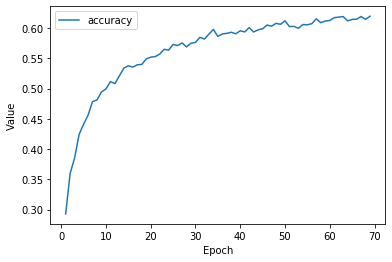

In [ ]:
# define the hyperparameters
learning_rate = 0.000008
epochs = 70
batch_size = 150
validation_split = 0.4


# Established model's topography
my_model = create_model(learning_rate)

# Train the model on normalized training set
epochs, hist = train_model(my_model, x_train_norm, y_train, epochs,
                          batch_size, validation_split)

# plot accuracy vs epochs of training
list_of_metrics_to_plot = ['accuracy'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
my_model.evaluate(x=x_test_norm, y=y_test, batch_size=batch_size)

4585/4585 [==============================] - 2s 521us/sample - loss: 1.6412 - accuracy: 0.6277


[1.6411519827993513, 0.627699]

# Convolutional Neural Network model

In [ ]:
# define Convolutional Neural Network model.
# we are implementing AlexNet architecture  for our CNN model
def create_cnn_model(learning_rate):
  """Create and compile deep neural net model"""
  model = tf.keras.models.Sequential()

  # Add 1st Convolutional layer
  model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4,4), 
                          activation='relu', input_shape=(100, 100, 3), padding='valid'))
  
  # Max Pooling
  model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
  
  # Add 2nd Convolutional layer
  model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), 
                          activation='relu', padding='same'))
   # Max Pooling
  model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

  # Add 3rd Convolutional layer
  model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1,1), 
                          activation='relu', padding='same'))
  
  # Add 4th Convolutional layer
  model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1,1), 
                          activation='relu', padding='same'))
  
  # Add 5th Convolutional layer
  model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), 
                          activation='relu', padding='same'))

  # Max pooling
  model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

  # passing to fully connected layer
  model.add(layers.Flatten())
  # Define the first fully connected layer
  model.add(layers.Dense(units=9216, activation='relu', name='fully1'))

  # Define a dropout regularization layer for first fully connected layer. 
  model.add(layers.Dropout(rate=0.5))

  # Define the second fully connected layer
  model.add(layers.Dense(units=4096, activation='relu', name='fully2'))

  # Define a dropout regularization layer for second fully connected layer. 
  model.add(layers.Dropout(rate=0.5))

  # Define third fully connected layer
  model.add(layers.Dense(units=1000, activation='relu', name='fully3'))

  # Define a dropout regularization layer for third fully connected layer. 
  model.add(layers.Dropout(rate=0.5))

  # Define the output layer
  model.add(layers.Dense(units=10,
                                  activation='softmax',
                                  name='Output'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model

In [ ]:
# define hyperparameters
epochs = 22
batch_size = 150
validation_split = 0.4
learning_rate = 0.00007

In [ ]:
# Established model's topography
my_model = create_cnn_model(learning_rate)

## Define train function for cnn model

In [ ]:
def train_cnn_model(model, train_features, train_label, epochs,
                batch_size, validation_split=0.05):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split=validation_split)
  
  # The list of epochs of the model
  epochs = history.epoch

  # gather a snapshot of the model's mean squared error
  # at each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist

## Train CNN model

Epoch 1/22
74/74 [==============================] - 6s 76ms/step - loss: 2.2365 - accuracy: 0.1308 - val_loss: 2.0013 - val_accuracy: 0.2159
Epoch 2/22
74/74 [==============================] - 4s 55ms/step - loss: 1.8353 - accuracy: 0.2922 - val_loss: 1.7710 - val_accuracy: 0.3294
Epoch 3/22
74/74 [==============================] - 4s 55ms/step - loss: 1.5551 - accuracy: 0.4272 - val_loss: 1.2948 - val_accuracy: 0.5218
Epoch 4/22
74/74 [==============================] - 4s 55ms/step - loss: 1.1557 - accuracy: 0.5859 - val_loss: 0.8549 - val_accuracy: 0.7056
Epoch 5/22
74/74 [==============================] - 4s 55ms/step - loss: 0.8661 - accuracy: 0.6891 - val_loss: 0.7152 - val_accuracy: 0.7416
Epoch 6/22
74/74 [==============================] - 4s 55ms/step - loss: 0.7462 - accuracy: 0.7340 - val_loss: 0.6782 - val_accuracy: 0.7561
Epoch 7/22
74/74 [==============================] - 4s 55ms/step - loss: 0.6340 - accuracy: 0.7703 - val_loss: 0.6660 - val_accuracy: 0.7626
Epoch 8/22
74

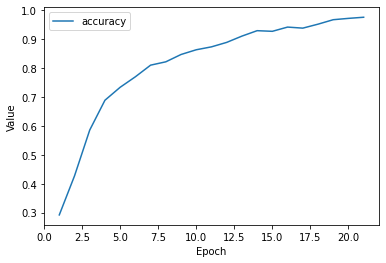

In [ ]:
# Train the model on normalized training set
epochs, hist = train_cnn_model(my_model, x_train_norm, y_train, epochs, batch_size, validation_split)

# plot accuracy vs epochs of training
list_of_metrics_to_plot = ['accuracy'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
my_model.evaluate(x=x_test_norm, y=y_test, batch_size=batch_size)

31/31 [==============================] - 1s 18ms/step - loss: 0.4593 - accuracy: 0.8661


[0.4592846632003784, 0.8660850524902344]